In [32]:
#Importing required libraries
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from textblob import TextBlob
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns

In [33]:
twitter = pd.read_csv("2020-03-16-tweets.csv")

In [34]:
twitter.columns

Index(['status_id', 'user_id', 'created_at', 'screen_name', 'text', 'source',
       'reply_to_status_id', 'reply_to_user_id', 'reply_to_screen_name',
       'is_quote', 'is_retweet', 'favourites_count', 'retweet_count',
       'country_code', 'place_full_name', 'place_type', 'followers_count',
       'friends_count', 'account_lang', 'account_created_at', 'verified',
       'lang'],
      dtype='object')

In [35]:
#Extracting only English tweets
twitter = twitter['text'][twitter['lang'] == 'en']

In [36]:
twitterdf = pd.DataFrame(twitter)

In [38]:
#Checking for empty rows
twitterdf.isna().sum()

text    0
dtype: int64

In [39]:
#Checking for empty strings
filt = twitterdf != ""

In [40]:
filt

,text
0,True
1,True
4,True
8,True
9,True
...,...
612476,True
612477,True
612478,True
612479,True


In [41]:
#Using NLTK library to download stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Subhiksha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [42]:
#Making a list of negation words
negation = ['no', 'nor', 'not','don', "don't", 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]

In [43]:
#Removing negation words from the stop words as they interfere while prediction negative sentiments
new_stop_words = list(set(stop_words) - set(negation))

In [44]:
new_stop_words.append('rt')

In [45]:
#Removing punctuations from strings

def remove_url_punctuation(txt):
    """Replace URLs found in a text string with nothing 
    (i.e. it will remove the URL from the string).

    Parameters
    ----------
    txt : string
        A text string that you want to parse and remove urls.

    Returns
    -------
    The same txt string with url's removed.
    """
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    no_url = url_pattern.sub(r'', txt)
    
    punct_pattern = re.compile(r'[^\w\s]')
    no_punct = punct_pattern.sub(r'', no_url)
    
    # Clean up punctuation (including pound signs)
    return no_punct

In [46]:
#Function to preprocess string passed

def preprocessingText(result_df):
    result_df = result_df.apply(lambda x: remove_url_punctuation(x) )
    #converting the text to lowercase for uniformity.
    result_df =  result_df.apply(lambda x: x.lower())  # everything to lowercase
    # removes punctuation
    #result_df =  result_df.str.replace('[^\w\s]','') 
    # Remove stop words
    result_df =  result_df.apply(lambda x: " ".join(x for x in x.split() if x not in new_stop_words))
    
    return  result_df

In [47]:
twitterdf['text'] = preprocessingText(twitterdf['text'])

In [48]:
twitterdf['text']

0         1600 cet sunday latest covid19 numbers report ...
1         metro manila community quarantine covid19 ligt...
4         glad see meals made available students county ...
8         covid19 telework got theres chat many public s...
9         paramilitary forces including crpf itbp bsf ad...
                                ...                        
612476        always one always florida florida coronavirus
612477    bit interesting history chemistry copper kills...
612478    pissed im go 2nd shift excited teach bfs daugh...
612479    brilliant idea happening right australia publi...
612480    antivaxxers prove worth tell theres herb cuddl...
Name: text, Length: 330465, dtype: object

In [49]:
#Using text blob to predict sentiment of each string in database
twitterdf["sentiment_value"] = twitterdf['text'].apply(lambda x: TextBlob(x).sentiment.polarity)

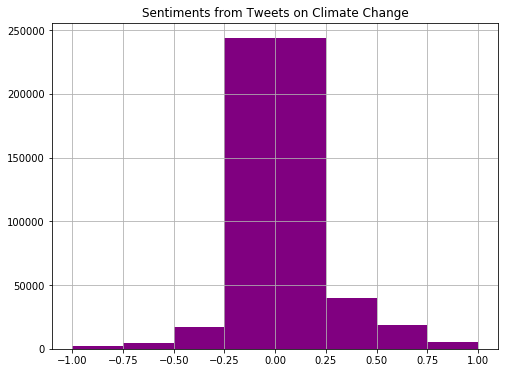

In [50]:
fig, ax = plt.subplots(figsize=(8, 6))

# Plot histogram of the polarity values
twitterdf['sentiment_value'].hist(bins=[-1, -0.75, -0.5, -0.25, 0.25, 0.5, 0.75, 1],
             ax=ax,
             color="purple")

plt.title("Sentiments from Tweets on Climate Change")
plt.show()

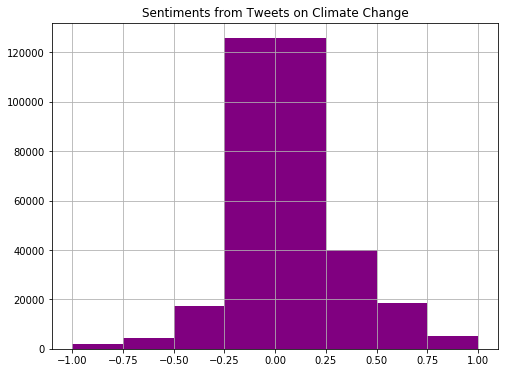

In [51]:
# Remove polarity values equal to zero

fig, ax = plt.subplots(figsize=(8, 6))

# Plot histogram of the polarity values
twitterdf['sentiment_value'][twitterdf.sentiment_value != 0].hist(bins=[-1, -0.75, -0.5, -0.25, 0.25, 0.5, 0.75, 1],
             ax=ax,
             color="purple")

plt.title("Sentiments from Tweets on Climate Change")
plt.show()

In [52]:
#Labeling negative tweets, positive tweets and neutral tweets

twitterdf['labels'] = twitterdf['sentiment_value'].apply(np.sign).replace({-1: 'Negative', 1: 'Positive', 0: 'Neutral'})

In [53]:
twitterdf['labels'].value_counts()

Positive    139994
Neutral     117891
Negative     72580
Name: labels, dtype: int64

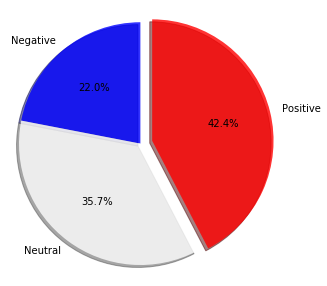

In [54]:
#Plot to show overall proportion of tweets in the database

sizes = [twitterdf['labels'].value_counts()[2], twitterdf['labels'].value_counts()[1], twitterdf['labels'].value_counts()[0]]
explode = (0, 0, 0.1)
labels = 'Negative', 'Neutral', 'Positive'
plt.figure(figsize=(5,5))
plt.pie(sizes, explode=explode, colors="bwr", labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90, wedgeprops={'alpha':0.8})
plt.axis('equal') 
plt.show()

This shows that majority people are positive or neutral about COVID in the subset of the COVID dataset chosen for analysis.

In [55]:
#Vectorization for Data Visualization

def vectorization(table):
    #CountVectorizer will convert a collection of text documents to a matrix of token counts
    #Produces a sparse representation of the counts 
    #Initialize
    vector = CountVectorizer()
    #We fit and transform the vector created
    frequency_matrix = vector.fit_transform(table.text)
    #Sum all the frequencies for each word
    sum_frequencies = np.sum(frequency_matrix, axis=0)
    #Now we use squeeze to remove single-dimensional entries from the shape of an array that we got from applying np.asarray to
    #the sum of frequencies.
    frequency = np.squeeze(np.asarray(sum_frequencies))
    #Now we get into a dataframe all the frequencies and the words that they correspond to
    frequency_df = pd.DataFrame([frequency], columns=vector.get_feature_names()).transpose()
    return frequency_df

In [56]:
def top50list(data,label):
    data = vectorization(data[data['labels'] == label])
    data = data.reset_index(drop=False)
    data = data.sort_values([0,'index'], ascending = False)[0:101]
    return data

In [78]:
def graph(word_frequency, sent):
    labels = word_frequency['index'][0:50]
    title = "Word Frequency for %s" %sent
    #Plot the figures
    plt.figure(figsize=(10,5))
    plt.bar(np.arange(50), word_frequency[0][0:50], width = 0.9, 
            color = sns.color_palette("bwr"), alpha=0.5, 
            edgecolor = "black", capsize=8, linewidth=1);
    plt.xticks(np.arange(50), labels, rotation=90, size=14);
    plt.xlabel("50 more frequent words", size=14);
    plt.ylabel("Frequency", size=14);
    #plt.title('Word Frequency for %s', size=18) %sent;
    plt.title(title, size=18)
    plt.grid(False);
    plt.gca().spines["top"].set_visible(False);
    plt.gca().spines["right"].set_visible(False);
    plt.show() 

In [58]:
neutral_top50 = top50list(twitterdf, 'Neutral')

In [80]:
positive_top50 = top50list(twitterdf, 'Positive')

C:\Users\Subhiksha\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 12540 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Subhiksha\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 12540 missing from current font.
  font.set_text(s, 0, flags=flags)


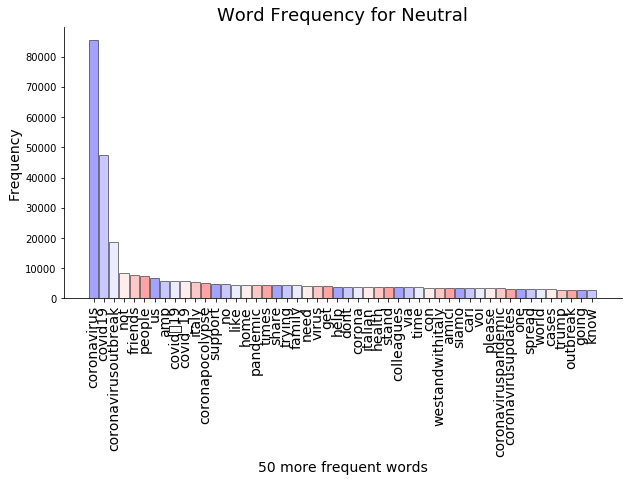

In [79]:
graph(neutral_top50, 'Neutral')

C:\Users\Subhiksha\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 12540 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Subhiksha\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 12540 missing from current font.
  font.set_text(s, 0, flags=flags)


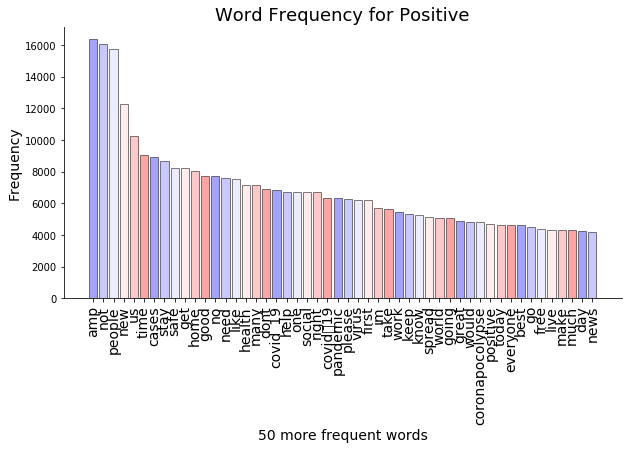

In [180]:
graph(positive_top50, 'Positive')

C:\Users\Subhiksha\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 12540 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Subhiksha\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 12540 missing from current font.
  font.set_text(s, 0, flags=flags)


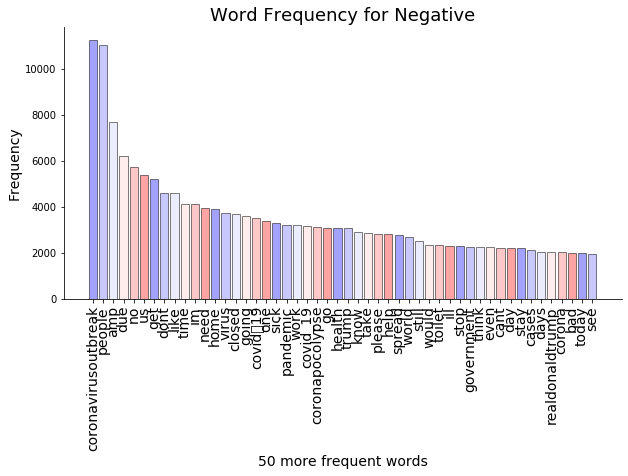

In [182]:
negative_top50 = top50list(twitterdf, 'Negative')
graph(negative_top50, 'Negative')

The graphs above show the most occuring words in each of the positive, negative and neutral tweets categories. This can be used to trace problems that people are talking about.